In [1]:
import os
import sys
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import random
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ROOT_DIR = "."
NOTEBOOK_ID = "AutoEncoders"
IMAGE_PATH = os.path.join(ROOT_DIR, "images", NOTEBOOK_ID)


2024-08-01 13:29:46.441251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 13:29:46.441325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 13:29:46.450450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 13:29:46.529254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 13:29:48.040850: W tensorflow/compiler/tf2

# Setup


In [2]:
# Set the random seed
random_seed = 42
tf.random.set_seed(random_seed)

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-01 13:29:51.349432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 13:29:51.430649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 13:29:51.430781: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


# Import images

We might as well use our image dataset I got from my father (Why am I writing as if I were teaching?)

In [4]:
data_path = Path("../data/smalldataset")

# Setup train and testing paths
train_dir = Path(data_path, "train")
test_dir = Path(data_path, "test")
val_dir = Path(data_path, "val")

train_dir, test_dir, val_dir

(PosixPath('../data/smalldataset/train'),
 PosixPath('../data/smalldataset/test'),
 PosixPath('../data/smalldataset/val'))

In [5]:


# Normalize all pixel values using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# A simple AutoEncoder

Autoencoders simply store a compressed (latent) representation of the input in the hidden layers
They should generate a somewhat lossy version of the input in their output layers

In [6]:
IMAGE_HEIGHT = 50  #224x224 will crash the kernel
IMAGE_WIDTH = 50
IMAGE_DEPTH = 3  # rgb

batch_size = 16
epochs = 100

In [7]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="input",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="input",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42)

Found 5308 images belonging to 66 classes.
Found 1718 images belonging to 66 classes.


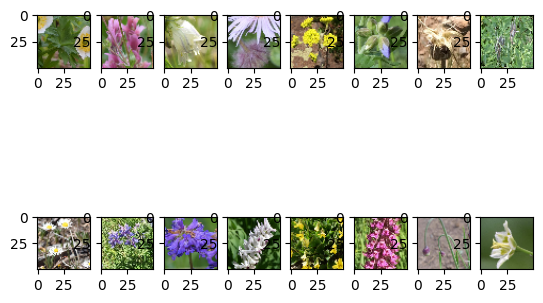

In [8]:
import math
#view a batch
num_rows = 2
num_cols = math.ceil(batch_size/num_rows)

x, y = next(train_data)
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [9]:
# create an encoder and decoder



encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH]),
    keras.layers.Dense(200, activation='selu'),
    keras.layers.Dense(50, activation='selu' )  #let's see how well this many neurons can encode such a big image... 
    ])

decoder = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=[50], activation='selu'),
    keras.layers.Dense(IMAGE_HEIGHT*IMAGE_WIDTH*IMAGE_DEPTH, activation='sigmoid'), # get back to original dimensions
    keras.layers.Reshape([IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH])   # get it back to an image shape
    ])
#hook them up, sequentially
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.5))

2024-08-01 13:29:53.770115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 13:29:53.770230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 13:29:53.770289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 13:29:53.925890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 13:29:53.925997: I external/local_xla/xla/stream_executor

In [10]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dense (Dense)               (None, 200)               1500200   
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
Total params: 1510250 (5.76 MB)
Trainable params: 1510250 (5.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               10200     
                                                                 
 dense_3 (Dense)             (None, 7500)              1507500   
                                                                 
 reshape (Reshape)           (None, 50, 50, 3)         0         
                                                                 
Total params: 1517700 (5.79 MB)
Trainable params: 1517700 (5.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 50)                1510250   
                                                                 
 sequential_1 (Sequential)   (None, 50, 50, 3)         1517700   
                                                                 
Total params: 3027950 (11.55 MB)
Trainable params: 3027950 (11.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ooh 90 million params... hmm... well, might be too big to deal with on my local machine

In [13]:
sae_history = autoencoder.fit(train_data, epochs=epochs, validation_data=(test_data))

Epoch 1/100


2024-08-01 13:30:00.373886: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9b7449be20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-01 13:30:00.373933: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-08-01 13:30:00.389350: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1722540600.455601  911221 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


332/332 [==============================] - 10s 19ms/step - loss: 0.6765 - val_loss: 0.6653
Epoch 2/100
332/332 [==============================] - 6s 18ms/step - loss: 0.6580 - val_loss: 0.6536
Epoch 3/100
332/332 [==============================] - 6s 19ms/step - loss: 0.6487 - val_loss: 0.6483
Epoch 4/100
332/332 [==============================] - 6s 19ms/step - loss: 0.6433 - val_loss: 0.6436
Epoch 5/100
332/332 [==============================] - 7s 20ms/step - loss: 0.6396 - val_loss: 0.6418
Epoch 6/100
332/332 [==============================] - 6s 17ms/step - loss: 0.6368 - val_loss: 0.6362
Epoch 7/100
332/332 [==============================] - 6s 19ms/step - loss: 0.6337 - val_loss: 0.6331
Epoch 8/100
332/332 [==============================] - 7s 22ms/step - loss: 0.6316 - val_loss: 0.6307
Epoch 9/100
332/332 [==============================] - 6s 18ms/step - loss: 0.6295 - val_loss: 0.6300
Epoch 10/100
332/332 [==============================] - 6s 19ms/step - loss: 0.6275 - val_los

In [14]:
STEP_SIZE_TEST=test_data.n//test_data.batch_size
test_data.reset()
pred=autoencoder.predict(test_data,steps=STEP_SIZE_TEST,verbose=1)

107/107 [==============================] - 2s 15ms/step


In [15]:
import matplotlib.image as mpimg

In [16]:
x,_ = next(test_data)

In [17]:
x.shape

(16, 50, 50, 3)

In [18]:
x[1].shape

(50, 50, 3)

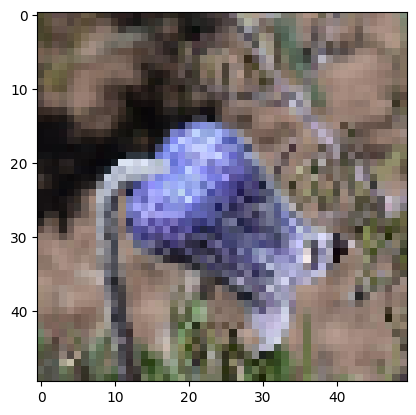

In [19]:
plt.imshow(x[1])

In [20]:
reconstructions = autoencoder.predict(x)


1/1 [==============================] - 0s 88ms/step


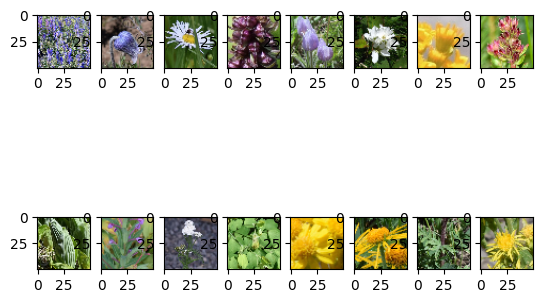

In [21]:

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))

1/1 [==============================] - 0s 21ms/step


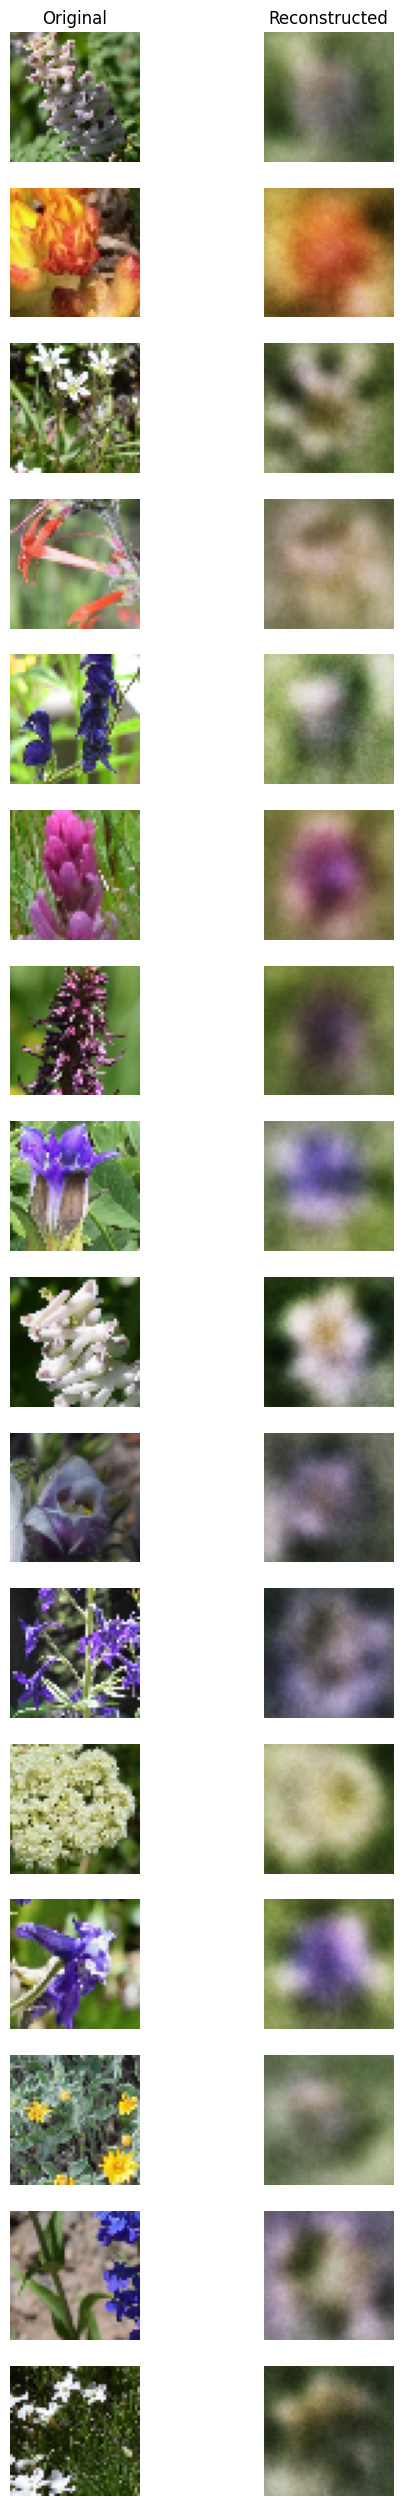

In [22]:
n_images = batch_size
new_images_orig,_ = next(test_data)  #get a batch of images
new_images_reconstructed = autoencoder.predict(new_images_orig)

plt.figure(figsize=(6, batch_size * 2))
for index in range(batch_size):
    plt.subplot(batch_size, 2, index * 2 + 1)#rows, cols, index
    plt.imshow(new_images_orig[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(batch_size, 2, index * 2 + 2)
    plt.imshow(new_images_reconstructed[index])
    plt.axis('off')
    if index == 0:
        plt.title("Reconstructed")
plt.show()

Pretty rough, but considering the training time, number of neurons, etc... not too bad.  Surely a CNN based network could do better?